In [ ]:
''' 유전 알고리즘 멀티 프로세싱 구현 '''
''' 
    멀티 프로세싱으로 배정할 작업 목록
    - 개체군 적합도 평가(완료)
    -- 1. 개체군을 여러 개의 부분 집합으로 분할한다
    -- 2. worker 프로세스에게 부분 집합을 전달한 후, 그에 대한 적합도 평가를 수행하도록 한다
    -- 3. 적합도 평가가 완료되었다면 각 개체의 개체군 내 인덱스와 적합도 점수를 boss 프로세스에게 반환한다
    - 다음 개체군 생성(진행중)
    -- 1. 여러 개의 토너먼트를 추출 및 배치 단위로 분할한다
    -- 2. 토너먼트 배치를 worker 프로세스에게 전달한 후, 그로부터 자손 개체를 생성하도록 한다
    -- 3. 생성된 자손 개체를 boss 프로세스에게 반환한다
'''

In [1]:
''' 공유 텐서로 프로세스들의 동작을 동기화할 수 있음을 확인했다 '''
import torch
import torch.multiprocessing as mp
from lib.worker_testing4 import worker

# def testing(num, bucket_tensor, event_count):
#     done = False
#     while not done:
#         if event_count == 8: done = True
#     print(f"event_count : {event_count}")
    
#     for i in range(10):
#         bucket_tensor[num*10+i] = num*10+i
    
bucket_tensor = torch.zeros(80)
event_count = torch.tensor([0])
bucket_tensor.share_memory_()
event_count.share_memory_()

p_num = 8
p_pool = []

for i in range(p_num):
    p = mp.Process(target=worker, args=(i, bucket_tensor, event_count))
    p_pool.append(p)
    p.start()

for p in p_pool:
    p.join()
    p.terminate()
    p.close()

print(bucket_tensor)

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
        28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41.,
        42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55.,
        56., 57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69.,
        70., 71., 72., 73., 74., 75., 76., 77., 78., 79.])


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torch.multiprocessing as mp
from lib.eval_gene_worker import evaluate as e_worker
from lib.next_gen_worker import next_generation as ng_worker

''' boss 프로세스 '''
def spawn_population(pop_size, layers):
    tot_params_num = sum([np.prod(l) + l[1] for l in layers])
    params_set = torch.randn(pop_size, tot_params_num)
    fitness_set = torch.zeros(pop_size, dtype=torch.intsdfsdf)

    return params_set, fitness_set

def evaluate_management(p_num, layers, parmas_set, fitness_set):
    lp = params_set.shape[0] # 개체군 크기
    batch_range = np.arange(0, lp + 1, lp // p_num)
    batch_range[-1] = lp
    p_pool = []
    
    for i in range(p_num):
        p = mp.Process(target=e_worker, args=(batch_range[i:i+2], layers, params_set, fitness_set)) # 프로세스 생성
        p_pool.append(p)
        p.start() # worker 프로세스 실행
    
    for p in p_pool:
        p.join() # worker 프로세스가 작업을 완료할 때 까지 boss 프로세스가 간섭하지 못하도록 방지
        p.terminate() # worker 프로세스 종료
        p.close() # worker 프로세스 해제

def next_generation_management(p_num, tournament_size, mut_rate, params_set, fitness_set, event_count):
    lp = params_set.shape[0] # 개체군의 크기
    lt = lp // 2 # 한 개체군으로 다음 개체군을 만들기 위해 필요한 토너먼트의 개수
    tour_quota = np.arange(0, lt + 1, lt // p_num) # worker 프로세스에게 처리해야 할 토너먼트를 분할해주기 위한 범위 계산
    tour_quota[-1] = lt
    p_pool = []
    
    for i in range(p_num):
        # tour_quota[i:i+2]는 각 프로세스에게 처리해야 하는 토너먼트의 수량을 알려준다
        p = mp.Process(target=ng_worker, args=(tour_quota[i:i+2], tournament_size, mut_rate, params_set, fitness_set, event_count)) # 프로세스 생성
        p_pool.append(p)
        p.start() # worker 프로세스 실행
    
    for p in p_pool:
        p.join() # worker 프로세스가 작업을 완료할 때 까지 boss 프로세스가 간섭하지 못하도록 방지
        p.terminate() # worker 프로세스 종료
        p.close() # worker 프로세스 해제

def running_mean(x, n=5): # 개체군 마다의 적합도 평균 모음을 입력으로 받는다
    conv = np.ones(n) # 데이터를 n개 단위로 행렬곱을 통해 합산하기 위한 것이다
    y = np.zeros(x.shape[0] - n + 1) # 전체 데이터를 T라고 했을 때 n개의 데이터를 한 개의 집합으로 간주하면, 총 T - n + 1개의 집합이 도출된다
    for i in range(x.shape[0] - n + 1):
        y[i] = (conv @ x[i:i+n]) / n # 데이터를 n개 단위로 평균을 계산한다

    return y

pop_size = 500
layers = [(4, 25), (25, 10), (10, 2)]
params_set, fitness_set = spawn_population(pop_size, layers)
event_count = torch.tensor([0])
params_set.share_memory_()
fitness_set.share_memory_()
event_count.share_memory_()

p_num = 8
generation = 20
tournament_size = 0.2
mut_rate = 0.01
avg_fits = []

start = time.time()
for i in range(generation):
    evaluate_management(p_num, layers, params_set, fitness_set)
    avg_fits.append(fitness_set.mean().item())
    next_generation_management(p_num, tournament_size, mut_rate, params_set, fitness_set, event_count)
print(f"running time : {(time.time() - start) / 60:.4f} min")

# print(f"max fitness of gene of final population : {max_gene(pop)}")

''' 개체군 저장 '''
torch.save(params_set, os.path.join(os.getcwd(), "parameters", "params_set1.pt"))
torch.save(fitness_set, os.path.join(os.getcwd(), "parameters", "fitness_set1.pt"))

plt.figure(figsize=(12,7))
plt.xlabel("Generations", fontsize=22)
plt.ylabel("Score", fontsize=22)
plt.plot(running_mean(np.array(avg_fits), 3))

KeyboardInterrupt: 

In [ ]:
''' 개체 평가 worker 프로세스 '''
import gymnasium as gym
import numpy as np
import torch
from torch import nn

class LR_block(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.linear = nn.Linear(shape[0], shape[1])
        self.relu = nn.ReLU()
        # 유전 알고리즘의 학습은 역전파를 통한 학습과 다르므로 배치 정규화와 드롭아웃은 사용해봐야 의미가 없다

    def forward(self, x):
        output = self.relu(self.linear(x))

        return output

class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.body = nn.Sequential(*[LR_block(shape) for shape in layers[:-1]])
        self.tail_top = nn.Linear(layers[-1][0], layers[-1][1])
        self.tail_bottom = nn.LogSoftmax(dim=0)

    def forward(self, x):
        output = self.body(x)
        output = self.tail_bottom(self.tail_top(output))

        return output

def unpack_params(params_vec, layers):
    # 만약 어떤 은닉층이 노드가 10개이고 크기가 4인 1차원 텐서가 입력이라면
    # 이 은닉층의 가중치 텐서는 10 X 4 형태의 텐서가 된다
    # params는 모델을 이루는 모든 계층들의 학습 가능한 매개변수들을 1차원 텐서 형태로 만들어 놓은 것이다(flatten)
    unpacked_params = []
    start = 0
    for l in layers:
        division = np.prod(l)
        stop = start + division + l[1]
        layer_vec = params_vec[start:stop] # 각 계층의 매개변수 벡터를 추출한다
        unpacked_params.extend([layer_vec[0:division].reshape((l[1], l[0])), layer_vec[division:]]) # 각 계층에 해당하는 매개변수 벡터로부터 다시 가중치 벡터와 편향 벡터를 추출한다
        start = stop

    return unpacked_params

def reconstruct_state_dict(state_dict, parameters_set):
    for i, key in enumerate(state_dict):
        state_dict[key].copy_(parameters_set[i]) # 모델의 매개변수 텐서를 개체의 매개변수 텐서로 모두 덮어씌운다

    return state_dict

def evaluate(batch, layers, params_set, fitness_set):
    model = Model(layers)
    state_dict = model.state_dict()

    done = False
    score = 0
    env = gym.make("CartPole-v1")
    
    for idx in range(*batch):
        ''' 개체를 모델로 구현 '''
        model.load_state_dict(reconstruct_state_dict(state_dict, unpack_params(params_set[idx], layers)))

        ''' 개체 평가 '''
        cur_state = torch.from_numpy(env.reset()[0]).float()
        while not done: # done = True이면 반복문이 종료된다
            with torch.no_grad():
                logits = model(cur_state) # logits아닌 probs로 적혀있었던 것이 유전 알고리즘의 테스트에서 의도대로 작동하지 않았던 원인이었다
                                          # probs로 적어놨기 때문에 아래의 카테고리컬 분포 계산이 잘못 계산되었던 것이다
            action = torch.distributions.categorical.Categorical(logits=logits).sample() # logit을 바탕으로 카테고리컬 분포(즉, 확률분포)를 구성한 후, 그에 따라 행동 1개를 선택한다
            next_state, _, done, _, _ = env.step(action.item())
            cur_state = torch.from_numpy(next_state).float()
            score += 1 # 에피소드의 길이를 각 개체에 대한 적합도 점수로 간주한다
        
        fitness_set[idx] = score
        score = 0
        done = False

In [ ]:
''' 다음 개체군 생성 worker 프로세스 '''
import numpy as np
import torch

def recombine(x1, x2):
    split_pt = np.random.randint(x1.shape[0]) # pt = point, 부모 개체의 교차점을 무작위로 추출한다
    # 자손 개체 생성
    child1 = torch.cat((x1[0:split_pt], x2[split_pt:]), dim=0) # 부모 텐서와는 완전히 별개인 새로운 텐서가 생성된다
    child2 = torch.cat((x2[0:split_pt], x1[split_pt:]), dim=0) # 부모 텐서와는 완전히 별개인 새로운 텐서가 생성된다

    return child1, child2

def mutate(x, rate=0.01):
    num_to_change = int(rate*x.shape[0]) # 자손 개체의 매개변수들 중 변이시킬 매개변수 비율을 결정한다
    idx = np.random.randint(low=0, high=x.shape[0], size=(num_to_change,)) # 결정된 비율만큼의 매개변수 인덱스를 반환한다
    x[idx] = torch.randn(num_to_change) / 10.0 # 선택된 매개변수들을 모두 무작위 실수 값으로 변경한다
                                               # 10.0으로 굳이 나누어 준 것은 모든 무작위 실수 값들이 0.xxx의 형태로 표현되도록 만들어 주기 위함이다
    return x

def next_generation(tour_quota, mut_rate, tournament_size, params_set, fitness_set, event_count):
    lp = params_set.shape[0] # 개체군의 크기
    temp = []

    ''' 자손 개체 생성 '''
    for i in range(*tour_quota):
        # 토너먼트 생성 및 부모 개체 선정
        tournament = np.random.randint(low=0, high=lp, size=(int(tournament_size*lp))) # 토너먼트에 참여할 개체를 추출한다
        tournament = np.array([[idx, fitness_set[idx]] for idx in tournament]) # 토너먼트를 재구성한다
        tournament = tournament[tournament[:, 1].argsort()] # 토너먼트에 속한 개체들을 적합도 점수를 기준으로 내림차순으로 정렬한 결과가 반환된다
        p1, p2 = params_set[tournament[-1][0]], params_set[tournament[-2][0]]

        # 자식 개체 생성
        offsprings = recombine(p1, p2)
        temp.extend([mutate(offsprings[0], mut_rate), mutate(offsprings[1], mut_rate)])

    ''' 현재 개체군에 생성된 자손 개체를 덮어씌우기 '''
    # 모든 worker 프로세스가 할당받은 토너먼트로부터 자손 개체의 생성을 완료할 때까지 대기(그렇지 않으면 다른 프로세스가 현세대 개체군으로 자손 개체를 생성할 수 없다)
    event_count += 1
    while True:
        if event_count == 8 : break
    print(f"event_count : {event_count}")
    
    # 1번 프로세스가 30개의 토너먼트(토너먼트 범위 [0:30])를 처리했다면 60개의 자손 개체가 생성된다
    # 그리고 이 60개의 자손 개체는 현세대 개체군의 인덱스 범위 [0:60]에 대입한다
    # 마찬가지의 논리로 2번 프로세스로부터(토너먼트 범위 [30:60]) 생성된 60개의 자손 개체는 현세대 개체군의 인덱스 범위 [60:120]에 대입한다
    # 위와 같은 과정을 모든 프로세스에서 수행하여 기존의 개체군을 새로운 개체군으로 갱신하도록 하는 것이 아래 인덱스 슬라이싱의 의미이다
    params_set[2*tour_quota[0]:2*tour_quota[1]] = temp[:]

In [ ]:
''' 모델을 클래스로 구성한 버전 '''
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import time, os
import torch
from torch import nn
import torch.multiprocessing as mp
from lib.model_testing3 import worker

env = gym.make("CartPole-v1")

class LR_block(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.linear = nn.Linear(shape[0], shape[1])
        self.relu = nn.ReLU()
        # 유전 알고리즘의 학습은 역전파를 통한 학습과 다르므로 배치 정규화와 드롭아웃은 사용해봐야 의미가 없다

    def forward(self, x):
        output = self.relu(self.linear(x))

        return output

class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.body = nn.Sequential(*[LR_block(shape) for shape in layers[:-1]])
        self.tail_top = nn.Linear(layers[-1][0], layers[-1][1])
        self.tail_bottom = nn.LogSoftmax(dim=0)

    def forward(self, x):
        output = self.body(x)
        output = self.tail_bottom(self.tail_top(output))

        return output

def spawn_population(N, layers):
    # 개체군
    gene_size = sum([l[1] * (l[0] + 1) for l in layers]) # 각 계층별 학습 가능한 매개변수의 개수를 계산한 후, 총 학습 가능한 매개변수의 개수를 계산한다
    pop = [{"params":(torch.randn(gene_size) / 2.0), "fitness":0.0} for i in range(N)] # 모델의 모든 학습 가능한 매개변수에 해당하는 무작위한 값들로 채워진 1차원 텐서를 생성한다(개체 생성)

    return pop

def unpack_params(params, layers):
    # 만약 어떤 은닉층이 노드가 10개이고 크기가 4인 1차원 텐서가 입력이라면
    # 이 은닉층의 가중치 텐서는 10 X 4 형태의 텐서가 된다
    # params는 모델을 이루는 모든 계층들의 학습 가능한 매개변수들을 1차원 텐서 형태로 만들어 놓은 것이다(flatten)
    unpacked_params = []
    start = 0
    for l in layers:
        division = np.prod(l)
        stop = start + division + l[1]
        layer_vec = params[start:stop] # 각 계층의 매개변수 벡터를 추출한다
        unpacked_params.extend([layer_vec[0:division].reshape((l[1], l[0])), layer_vec[division:]]) # 각 계층에 해당하는 매개변수 벡터로부터 다시 가중치 벡터와 편향 벡터를 추출한다
        start = stop

    return unpacked_params

def recombine(x1, x2):
    x1 = x1["params"] # 모델의 flatten된 매개변수 텐서를 불러온다
    x2 = x2["params"]
    split_pt = np.random.randint(x1.shape[0]) # pt = point, 부모 개체의 교차점을 무작위로 추출한다
    # 최종 자손 개체
    child1 = {"params":torch.cat((x1[0:split_pt], x2[split_pt:]), dim=0), "fitness":0.0} # 첫 번째 자손 개체 생성
    child2 = {"params":torch.cat((x2[0:split_pt], x1[split_pt:]), dim=0), "fitness":0.0} # 두 번째 자손 개체 생성

    return child1, child2

def mutate(x, rate=0.01):
    x_params = x["params"]
    num_to_change = int(rate*x_params.shape[0]) # 자손 개체의 매개변수들 중 변이시킬 매개변수 비율을 결정한다
    idx = np.random.randint(low=0, high=x_params.shape[0], size=(num_to_change,)) # 결정된 비율만큼의 매개변수 인덱스를 반환한다
    x_params[idx] = torch.randn(num_to_change) / 10.0 # 선택된 매개변수들을 모두 무작위 실수 값으로 변경한다
                                                      # 10.0으로 굳이 나누어 준 것은 모든 무작위 실수 값들이 0.xxx의 형태로 표현되도록 만들어 주기 위함이다
    x["params"] = x_params

    return x

def reconstruct_state_dict(state_dict, parameters_set):
    for i, key in enumerate(state_dict):
        state_dict[key].copy_(parameters_set[i]) # 모델의 매개변수 텐서를 개체의 매개변수 텐서로 모두 덮어씌운다

    return state_dict

def test_model(gene, layers):
    model = Model(layers)
    model.load_state_dict(reconstruct_state_dict(model.state_dict(), unpack_params(gene["params"], layers))) # 개체를 토대로 모델을 구성한다
    
    done = False
    cur_state = torch.from_numpy(env.reset()[0]).float()
    score = 0

    while not done: # done = True이면 반복문이 종료된다
        with torch.no_grad():
            logits = model(cur_state) # logits아닌 probs로 적혀있었던 것이 유전 알고리즘의 테스트에서 의도대로 작동하지 않았던 원인이었다
                                      # probs로 적어놨기 때문에 아래의 카테고리컬 분포 계산이 잘못 계산되었던 것이다
        action = torch.distributions.categorical.Categorical(logits=logits).sample() # logit을 바탕으로 카테고리컬 분포(즉, 확률분포)를 구성한 후, 그에 따라 행동 1개를 선택한다
        next_state, _, done, _, _ = env.step(action.item())
        cur_state = torch.from_numpy(next_state).float()
        score += 1 # 에피소드의 길이를 각 개체에 대한 적합도 점수로 간주한다

    return score

def evaluate_population(pop, layers):
    tot_fit = 0
    for gene in pop:
        score = test_model(gene, layers) # 개체가 카트폴 환경에 얼마나 적합한지 평가한다
        gene["fitness"] = score
        tot_fit += score
    avg_fit = tot_fit / len(pop) # 개체군 내 모든 개체들의 적합도에 대한 평균을 계산한다

    return pop, avg_fit

def next_generation(pop, mut_rate=0.001, tournament_size=0.2):
    new_pop = []
    lp = len(pop) # lp = length population
    while len(new_pop) < lp:
        ''' 부모 개체 선택 '''
        sg = np.random.randint(low=0, high=lp, size=(int(tournament_size*lp))) # [0, lp) 구간에서 (tournament_size*lp) 만큼의 무작위 정수들을 추출한다
                                                                                      # 즉, 전체 개체군에서 부모 개체를 선택하기 위한 부분 집합을 선발한다
        sg = np.array([[i, x["fitness"]] for (i, x) in enumerate(pop) if i in sg]) # sg = selection group
        scores = sg[sg[:, 1].argsort()] # np.argsort()는 주어진 축(axis)에 따라 배열을 (내림차순으로)정렬한 후, 그 형태를 유지한 채로 각 원소들이 정렬되기 전 원래 가졌었던 인덱스를 반환한다
                                        # scores는 적합도를 기준으로 내림차순으로 정렬된 개체 정보 ndarray이다
        p0, p1 = pop[int(scores[-1][0])], pop[int(scores[-2][0])] # scores는 sg 내의 개체들을 내림차순으로 정렬한 것이므로 적합도가 가장 큰 개체는 맨 마지막에서 첫 번째와 두 번째 개체가 된다
                                                                  # 적합도가 가장 큰 두 개체의 개체군 내 인덱스를 반환한다
        ''' 자손 개체 생성 '''
        offspring = recombine(p0, p1)
        new_pop.extend([mutate(offspring[0], rate=mut_rate), mutate(offspring[1], rate=mut_rate)]) # 최종 자손 개체

    return new_pop

def max_gene(pop, layers):
    pop, _ = evaluate_population(pop, layers)
    max_fitness = 0
    for x in pop:
        if x["fitness"] > max_fitness: max_fitness = x["fitness"]

    return max_fitness

def running_mean(x, n=5): # 개체군 마다의 적합도 평균 모음을 입력으로 받는다
    conv = np.ones(n) # 데이터를 n개 단위로 행렬곱을 통해 합산하기 위한 커널(필터)이다
    y = np.zeros(x.shape[0] - n + 1) # 전체 데이터를 T라고 했을 때 n개의 데이터를 한 개의 집합으로 간주하면, 총 T - n + 1개의 집합이 도출된다
    for i in range(x.shape[0] - n + 1):
        y[i] = (conv @ x[i:i+n]) / n # 데이터를 n개 단위로 평균을 계산한다

    return y

In [14]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import time, os
import torch
import torch.multiprocessing as mp
from lib.model_testing2 import worker

env = gym.make("CartPole-v1")

def model(x, unpacked_params):
    l1, b1, l2, b2, l3, b3 = unpacked_params
    y = torch.nn.functional.linear(x, l1, b1) # torch.nn.functional.linear()에는 입력과 가중치 텐서, 편향 텐서가 인자로 전달된다
    y = torch.relu(y)
    y = torch.nn.functional.linear(y, l2, b2)
    y = torch.relu(y)
    y = torch.nn.functional.linear(y, l3, b3)
    y = torch.log_softmax(y, dim=0)

    return y

def unpack_params(params, layers=[(25, 4), (10, 25), (2, 10)]):
    # 만약 어떤 은닉층이 노드가 10개이고 크기가 4인 1차원 텐서가 입력이라면
    # 이 은닉층의 가중치 텐서는 10 X 4 형태의 텐서가 된다
    # params는 모델을 이루는 모든 계층들의 학습 가능한 매개변수들을 1차원 텐서 형태로 만들어 놓은 것이다(flatten)
    unpacked_params = []
    e = 0
    for i, l in enumerate(layers):
        s, e = e, e + np.prod(l) # np.prod()는 주어진 축(axis) 상의 배열 원소들에 대한 곱을 수행한다
        weights = params[s:e].view(l) # 첫 번째 은닉층부터 시작하여 각 계층의 가중치 텐서를 params로부터 추출한다
        s, e = e, e+l[0]
        bias = params[s:e] # 첫 번째 은닉층부터 시작하여 각 계층의 편향 텐서를 params로부터 추출한다
        unpacked_params.extend([weights, bias])

    return unpacked_params

def spawn_population(N=50, size=407):
    pop = [] # 개체군
    for i in range(N):
        vec = torch.randn(size) / 2.0 # 모델의 모든 학습 가능한 매개변수에 해당하는 무작위한 값들로 채워진 1차원 텐서를 생성한다
        fit = 0 # 각 개체의 적합도
        p = {"params":vec, "fitness":fit} # 개체 생성
        pop.append(p)

    return pop

def recombine(x1, x2):
    x1 = x1["params"] # 모델의 flatten된 매개변수 텐서를 불러온다
    x2 = x2["params"]
    l = x1.shape[0]
    split_pt = np.random.randint(l)
    child1 = torch.zeros(l)
    child2 = torch.zeros(l)
    # 첫 번째 자손 개체 생성
    child1[0:split_pt] = x1[0:split_pt]
    child1[split_pt:] = x2[split_pt:]
    # 두 번째 자손 개체 생성
    child2[0:split_pt] = x2[:split_pt]
    child2[split_pt:] = x1[split_pt:]
    # 최종 자손 개체
    c1 = {"params":child1, "fitness":0.0}
    c2 = {"params":child2, "fitness":0.0}

    return c1, c2

def mutate(x, rate=0.01):
    x_ = x["params"]
    num_to_change = int(rate*x_.shape[0]) # 자손 개체의 매개변수들 중 변이시킬 매개변수 비율을 결정한다
    idx = np.random.randint(low=0, high=x_.shape[0], size=(num_to_change,)) # 결정된 비율만큼의 매개변수 인덱스를 반환한다
    x_[idx] = torch.randn(num_to_change) / 10.0 # 선택된 매개변수들을 모두 무작위 실수 값으로 변경한다
                                                # 10.0으로 굳이 나누어 준 것은 모든 무작위 실수 값들이 0.xxx의 형태로 표현되도록 만들어 주기 위함이다
    x["params"] = x_

    return x

def test_model(agent):
    done = False
    s = env.reset()[0]
    state = torch.from_numpy(s).float()
    score = 0
    while not done: # done = True이면 반복문이 종료된다
        params = unpack_params(agent["params"])
        logits = model(state, params)
        action = torch.distributions.categorical.Categorical(logits=logits).sample() # logit을 바탕으로 카테고리컬 분포(즉, 확률분포)를 구성한 후, 그에 따라 행동 1개를 선택한다
        state_, reward, done, _, info = env.step(action.item())
        state = torch.from_numpy(state_).float()
        score += 1 # 에피소드의 길이를 각 개체에 대한 적합도 점수로 간주한다

    return score

def evaluate_population(pop):
    tot_fit = 0
    lp = len(pop) # lp = length population
    for agent in pop:
        score = test_model(agent)
        agent["fitness"] = score
        tot_fit += score
    avg_fit = tot_fit / lp # 개체군 내 모든 개체들의 적합도에 대한 평균을 계산한다

    return pop, avg_fit

def next_generation(pop, mut_rate=0.001, tournament_size=0.2):
    new_pop = []
    lp = len(pop) # lp = length population
    while len(new_pop) < len(pop):
        rids = np.random.randint(low=0, high=lp, size=(int(tournament_size*lp))) # [0, lp) 구간에서 (tournament_size*lp) 만큼의 무작위 정수들을 추출한다
                                                                                 # 즉, 전체 개체군에서 부모 개체를 선택하기 위한 부분 집합을 선발한다
        batch = np.array([[i, x["fitness"]] for (i, x) in enumerate(pop) if i in rids])
        scores = batch[batch[:, 1].argsort()] # np.argsort()는 주어진 축(axis)에 따라 배열을 (내림차순으로)정렬한 후, 그 형태를 유지한 채로 각 원소들이 정렬되기 전 원래 가졌었던 인덱스를 반환한다
                                              # scores는 적합도를 기준으로 내림차순으로 정렬된 개체 정보 ndarray이다
        i0, i1 = int(scores[-1][0]), int(scores[-2][0]) # scores가 내림차순으로 정렬되어 있으므로 적합도가 가장 높은 개체는 맨 마지막에서 첫 번째와 두 번째 개체가 된다
                                                       # 적합도가 가장 큰 두 개체의 개체군 내 인덱스를 반환한다
        parent0, parent1 = pop[i0], pop[i1] # 부모 개체
        offspring_ = recombine(parent0, parent1)
        child1 = mutate(offspring_[0], rate=mut_rate)
        child2 = mutate(offspring_[1], rate=mut_rate)
        offspring = [child1, child2] # 최종 자손 개체
        new_pop.extend(offspring)

    return new_pop

def max_gene(pop):
    pop, _ = evaluate_population(pop)
    max_fitness = 0
    for x in pop:
        if x["fitness"] > max_fitness: max_fitness = x["fitness"]

    return max_fitness

def running_mean(x, n=5): # 개체군 마다의 적합도 평균 모음을 입력으로 받는다
    conv = np.ones(n) # 데이터를 n개 단위로 행렬곱을 통해 합산하기 위한 것이다
    y = np.zeros(x.shape[0] - n + 1) # 전체 데이터를 T라고 했을 때 n개의 데이터를 한 개의 집합으로 간주하면, 총 T - n + 1개의 집합이 도출된다
    for i in range(x.shape[0] - n + 1):
        y[i] = (conv @ x[i:i+n]) / n # 데이터를 n개 단위로 평균을 계산한다

    return y

Gen 1
Gen 2
Gen 3
Gen 4
Gen 5
Gen 6
Gen 7
Gen 8
Gen 9
Gen 10
Gen 11
Gen 12
Gen 13
Gen 14
Gen 15
Gen 16
Gen 17
Gen 18
Gen 19
Gen 20
running time : 4.9333 min
max fitness of gene of final population : 1206


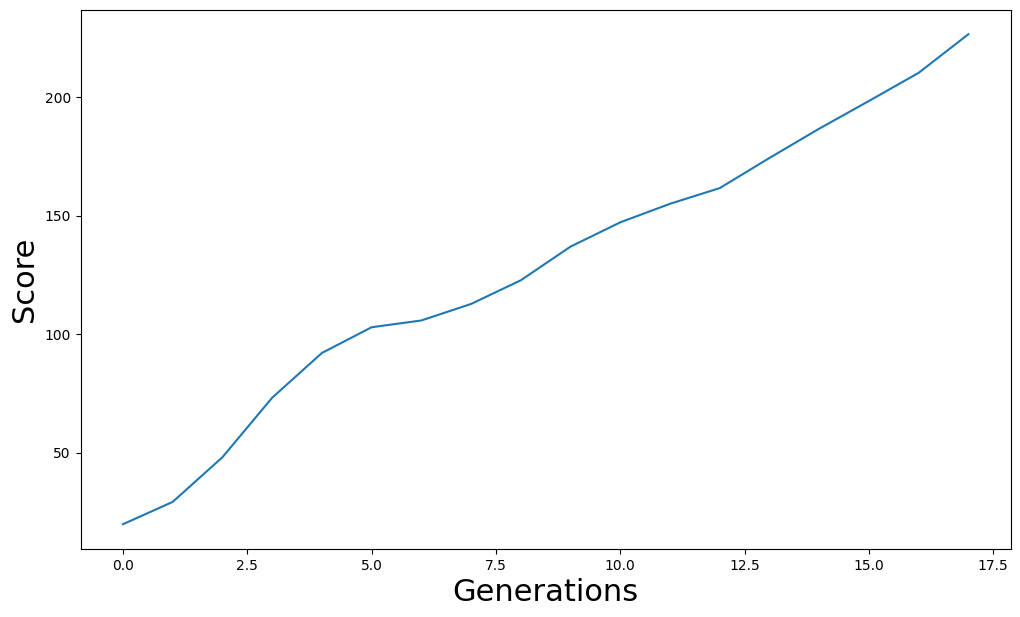

In [15]:
num_generations = 20
population_size = 500
mutation_rate = 0.01 # 1%
pop_fit = []
pop = spawn_population(N=population_size, size=407)

start = time.time()
for i in range(num_generations):
    print(f"Gen {i+1}")
    pop, avg_fit = evaluate_population(pop)
    pop_fit.append(avg_fit)
    pop = next_generation(pop, mut_rate=mutation_rate, tournament_size=0.2)
print(f"running time : {(time.time() - start) / 60:.4f} min")
# print(pop_fit, running_mean(np.array(pop_fit), 3))
print(f"max fitness of gene of final population : {max_gene(pop)}")

''' 개체군 저장 '''
torch.save(pop, os.path.join(os.getcwd(), "parameters", "population1.pt"))

plt.figure(figsize=(12,7))
plt.xlabel("Generations", fontsize=22)
plt.ylabel("Score", fontsize=22)
plt.plot(running_mean(np.array(pop_fit), 3))

In [16]:
''' 최종 개체군 중 최고의 적합도를 가진 개체에 대한 카트폴 실험 '''

''' 프로세스 생성 및 실행 '''
p = mp.Process(target=worker, args=(pop,))
p.start()

''' 프로세스 종료 및 자원 회수 '''
p.join()
p.terminate()
p.close()

In [11]:
''' 책에서 소개하는 코드의 최적화 버전 '''
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import time, os
import torch
import torch.multiprocessing as mp
from lib.model_testing2 import worker

env = gym.make("CartPole-v1")

def model(x, unpacked_params):
    l1, b1, l2, b2, l3, b3 = unpacked_params
    y = torch.nn.functional.linear(x, l1, b1) # torch.nn.functional.linear()에는 입력과 가중치 텐서, 편향 텐서가 인자로 전달된다
    y = torch.relu(y)
    y = torch.nn.functional.linear(y, l2, b2)
    y = torch.relu(y)
    y = torch.nn.functional.linear(y, l3, b3)
    y = torch.log_softmax(y, dim=0)

    return y

def unpack_params(params, layers=[(25, 4), (10, 25), (2, 10)]):
    # 만약 어떤 은닉층이 노드가 10개이고 크기가 4인 1차원 텐서가 입력이라면
    # 이 은닉층의 가중치 텐서는 10 X 4 형태의 텐서가 된다
    # params는 모델을 이루는 모든 계층들의 학습 가능한 매개변수들을 1차원 텐서 형태로 만들어 놓은 것이다(flatten)
    unpacked_params = []
    e = 0
    for l in layers:
        s, e = e, e + np.prod(l) # np.prod()는 주어진 축(axis) 상의 배열 원소들에 대한 곱을 수행한다
        weights = params[s:e].view(l) # 첫 번째 은닉층부터 시작하여 각 계층의 가중치 텐서를 params로부터 추출한다
        s, e = e, e+l[0]
        bias = params[s:e] # 첫 번째 은닉층부터 시작하여 각 계층의 편향 텐서를 params로부터 추출한다
        unpacked_params.extend([weights, bias])

    return unpacked_params

def spawn_population(N=50, size=407):
    # 개체군
    pop = [{"params":(torch.randn(size) / 2.0), "fitness":0.0} for i in range(N)] # 모델의 모든 학습 가능한 매개변수에 해당하는 무작위한 값들로 채워진 1차원 텐서를 생성한다(개체 생성)

    return pop

def recombine(x1, x2):
    x1 = x1["params"] # 모델의 flatten된 매개변수 텐서를 불러온다
    x2 = x2["params"]
    split_pt = np.random.randint(x1.shape[0]) # pt = point
    # 최종 자손 개체
    child1 = {"params":torch.cat((x1[0:split_pt], x2[split_pt:]), dim=0), "fitness":0.0} # 첫 번째 자손 개체 생성
    child2 = {"params":torch.cat((x2[0:split_pt], x1[split_pt:]), dim=0), "fitness":0.0} # 두 번째 자손 개체 생성

    return child1, child2

def mutate(x, rate=0.01):
    x_params = x["params"]
    num_to_change = int(rate*x_params.shape[0]) # 자손 개체의 매개변수들 중 변이시킬 매개변수 비율을 결정한다
    idx = np.random.randint(low=0, high=x_params.shape[0], size=(num_to_change,)) # 결정된 비율만큼의 매개변수 인덱스를 반환한다
    x_params[idx] = torch.randn(num_to_change) / 10.0 # 선택된 매개변수들을 모두 무작위 실수 값으로 변경한다
                                                      # 10.0으로 굳이 나누어 준 것은 모든 무작위 실수 값들이 0.xxx의 형태로 표현되도록 만들어 주기 위함이다
    x["params"] = x_params

    return x

def test_model(agent):
    done = False
    cur_state = torch.from_numpy(env.reset()[0]).float()
    score = 0
    agent_params = unpack_params(agent["params"]) # 개체의 매개변수 벡터를 모델의 각 계층에 넣어줄 수 있는 형식으로 변환한다
    while not done: # done = True이면 반복문이 종료된다
        with torch.no_grad():
            logits = model(cur_state, agent_params) # probs가 아니라 logits이다(이 구분에 따라 아래의 카테고리컬 함수가 작동하는 방식이 달라진다)
        action = torch.distributions.categorical.Categorical(logits=logits).sample() # logit을 바탕으로 카테고리컬 분포(즉, 확률분포)를 구성한 후, 그에 따라 행동 1개를 선택한다
        next_state, _, done, _, _ = env.step(action.item())
        cur_state = torch.from_numpy(next_state).float()
        score += 1 # 에피소드의 길이를 각 개체에 대한 적합도 점수로 간주한다

    return score

def evaluate_population(pop):
    tot_fit = 0
    lp = len(pop) # lp = length population
    for agent in pop:
        score = test_model(agent) # 개체가 카트폴 환경에 얼마나 적합한지 평가한다
        agent["fitness"] = score
        tot_fit += score
    avg_fit = tot_fit / lp # 개체군 내 모든 개체들의 적합도에 대한 평균을 계산한다

    return pop, avg_fit

def next_generation(pop, mut_rate=0.001, tournament_size=0.2):
    new_pop = []
    lp = len(pop) # lp = length population
    while len(new_pop) < len(pop):
        selection = np.random.randint(low=0, high=lp, size=(int(tournament_size*lp))) # [0, lp) 구간에서 (tournament_size*lp) 만큼의 무작위 정수들을 추출한다
                                                                                      # 즉, 전체 개체군에서 부모 개체를 선택하기 위한 부분 집합을 선발한다
        sg = np.array([[i, x["fitness"]] for (i, x) in enumerate(pop) if i in selection]) # sg = selection group
        scores = sg[sg[:, 1].argsort()] # np.argsort()는 주어진 축(axis)에 따라 배열을 (내림차순으로)정렬한 후, 그 형태를 유지한 채로 각 원소들이 정렬되기 전 원래 가졌었던 인덱스를 반환한다
                                        # scores는 적합도를 기준으로 내림차순으로 정렬된 개체 정보 ndarray이다
        p0, p1 = pop[scores[-1][0]], pop[scores[-2][0]] # scores는 sg 내의 개체들을 내림차순으로 정렬한 것이므로 적합도가 가장 큰 개체는 맨 마지막에서 첫 번째와 두 번째 개체가 된다
                                                                  # 적합도가 가장 큰 두 개체의 개체군 내 인덱스를 반환한다
        offspring = recombine(p0, p1)
        new_pop.extend([mutate(offspring[0], rate=mut_rate), mutate(offspring[1], rate=mut_rate)]) # 최종 자손 개체

    return new_pop

def max_gene(pop):
    pop, _ = evaluate_population(pop)
    max_fitness = 0
    for x in pop:
        if x["fitness"] > max_fitness: max_fitness = x["fitness"]

    return max_fitness

def running_mean(x, n=5): # 개체군 마다의 적합도 평균 모음을 입력으로 받는다
    conv = np.ones(n) # 데이터를 n개 단위로 행렬곱을 통해 합산하기 위한 커널(필터)이다
    y = np.zeros(x.shape[0] - n + 1) # 전체 데이터를 T라고 했을 때 n개의 데이터를 한 개의 집합으로 간주하면, 총 T - n + 1개의 집합이 도출된다
    for i in range(x.shape[0] - n + 1):
        y[i] = (conv @ x[i:i+n]) / n # 데이터를 n개 단위로 평균을 계산한다

    return y

Gen 1
Gen 2
Gen 3
Gen 4
Gen 5
Gen 6
Gen 7
Gen 8
Gen 9
Gen 10
Gen 11
Gen 12
Gen 13
Gen 14
Gen 15
Gen 16
Gen 17
Gen 18
Gen 19
Gen 20
running time : 3.7455 min
max fitness of gene of final population : 748


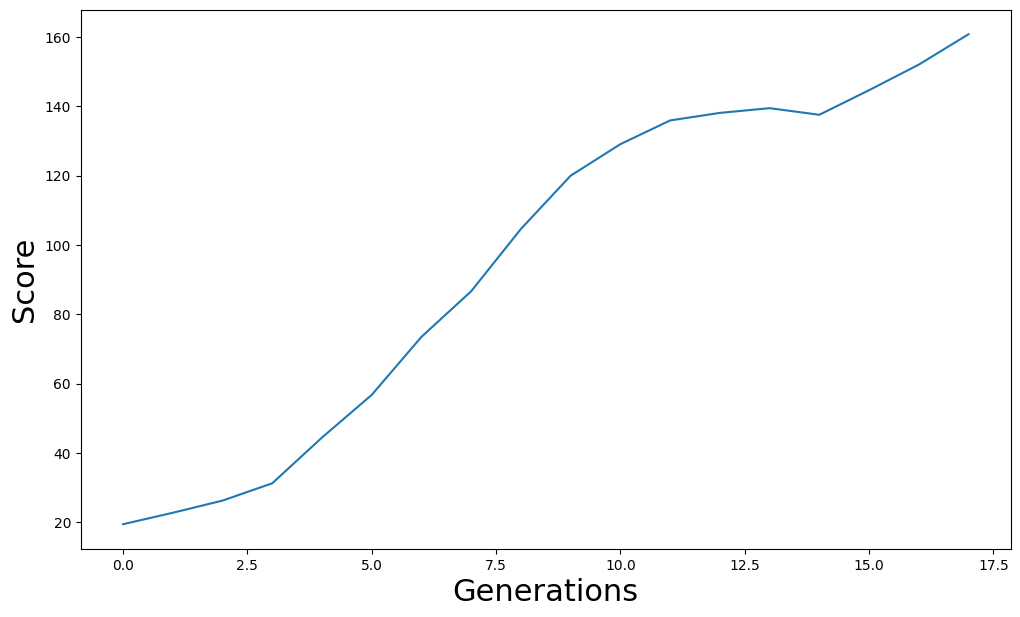

In [12]:
num_generations = 20
population_size = 500
mutation_rate = 0.01 # 0.1%
pop_fit = []
pop = spawn_population(N=population_size, size=407)

start = time.time()
for i in range(num_generations):
    print(f"Gen {i+1}")
    pop, avg_fit = evaluate_population(pop) # 개체군 내 개체들에 적합도 점수를 부여하고, 개체들의 적합도 점수 평균을 반환한다
    pop_fit.append(avg_fit)
    pop = next_generation(pop, mut_rate=mutation_rate, tournament_size=0.2)
print(f"running time : {(time.time() - start) / 60:.4f} min")
# print(pop_fit, running_mean(np.array(pop_fit), 3))
print(f"max fitness of gene of final population : {max_gene(pop)}")

''' 개체군 저장 '''
torch.save(pop, os.path.join(os.getcwd(), "parameters", "population2.pt"))

plt.figure(figsize=(12,7))
plt.xlabel("Generations", fontsize=22)
plt.ylabel("Score", fontsize=22)
plt.plot(running_mean(np.array(pop_fit), 3))

In [13]:
''' 최종 개체군 중 최고의 적합도를 가진 개체에 대한 카트폴 실험 '''

''' 프로세스 생성 및 실행 '''
p = mp.Process(target=worker, args=(pop,))
p.start()

''' 프로세스 종료 및 자원 회수 '''
p.join()
p.terminate()
p.close()

In [10]:
x = torch.randn((4,))
y = torch.nn.functional.linear(x, torch.randn((10, 4)), torch.randn((10,)))
print(y)

a = torch.randint(low=0, high=100, size=(20,))
b = torch.randint(low=0, high=20, size=(10,))
print("a :", a)
print("b :", b)
c = torch.randn(5)
a[b], c, c / 10.0

tensor([ 0.6518,  1.2223, -0.1558, -1.3645,  1.1768, -0.9971,  0.3373,  0.2208,
        -0.9163,  0.1216])
a : tensor([50, 10, 87, 37, 26, 68, 38,  5, 87, 71, 89, 66, 20, 81, 43, 99, 32, 25,
        95, 77])
b : tensor([ 7, 13, 13,  2,  8, 11, 10,  8, 13, 13])


(tensor([ 5, 81, 81, 87, 87, 66, 89, 87, 81, 81]),
 tensor([ 1.1274, -1.8803, -0.1561, -1.4720,  1.6622]),
 tensor([ 0.1127, -0.1880, -0.0156, -0.1472,  0.1662]))

In [4]:
''' 모델을 클래스로 구성한 버전 '''
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import time, os
import torch
from torch import nn
import torch.multiprocessing as mp
from lib.model_testing3 import worker

env = gym.make("CartPole-v1")

class LR_block(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.linear = nn.Linear(shape[0], shape[1])
        self.relu = nn.ReLU()
        # 유전 알고리즘의 학습은 역전파를 통한 학습과 다르므로 배치 정규화와 드롭아웃은 사용해봐야 의미가 없다

    def forward(self, x):
        output = self.relu(self.linear(x))

        return output

class Model(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.body = nn.Sequential(*[LR_block(shape) for shape in layers[:-1]])
        self.tail_top = nn.Linear(layers[-1][0], layers[-1][1])
        self.tail_bottom = nn.LogSoftmax(dim=0)

    def forward(self, x):
        output = self.body(x)
        output = self.tail_bottom(self.tail_top(output))

        return output

def spawn_population(N, layers):
    # 개체군
    gene_size = sum([l[1] * (l[0] + 1) for l in layers]) # 각 계층별 학습 가능한 매개변수의 개수를 계산한 후, 총 학습 가능한 매개변수의 개수를 계산한다
    pop = [{"params":(torch.randn(gene_size) / 2.0), "fitness":0.0} for i in range(N)] # 모델의 모든 학습 가능한 매개변수에 해당하는 무작위한 값들로 채워진 1차원 텐서를 생성한다(개체 생성)

    return pop

def unpack_params(params, layers):
    # 만약 어떤 은닉층이 노드가 10개이고 크기가 4인 1차원 텐서가 입력이라면
    # 이 은닉층의 가중치 텐서는 10 X 4 형태의 텐서가 된다
    # params는 모델을 이루는 모든 계층들의 학습 가능한 매개변수들을 1차원 텐서 형태로 만들어 놓은 것이다(flatten)
    unpacked_params = []
    start = 0
    for l in layers:
        division = np.prod(l)
        stop = start + division + l[1]
        layer_vec = params[start:stop] # 각 계층의 매개변수 벡터를 추출한다
        unpacked_params.extend([layer_vec[0:division].reshape((l[1], l[0])), layer_vec[division:]]) # 각 계층에 해당하는 매개변수 벡터로부터 다시 가중치 벡터와 편향 벡터를 추출한다
        start = stop

    return unpacked_params

def recombine(x1, x2):
    x1 = x1["params"] # 모델의 flatten된 매개변수 텐서를 불러온다
    x2 = x2["params"]
    split_pt = np.random.randint(x1.shape[0]) # pt = point, 부모 개체의 교차점을 무작위로 추출한다
    # 최종 자손 개체
    child1 = {"params":torch.cat((x1[0:split_pt], x2[split_pt:]), dim=0), "fitness":0.0} # 첫 번째 자손 개체 생성
    child2 = {"params":torch.cat((x2[0:split_pt], x1[split_pt:]), dim=0), "fitness":0.0} # 두 번째 자손 개체 생성

    return child1, child2

def mutate(x, rate=0.01):
    x_params = x["params"]
    num_to_change = int(rate*x_params.shape[0]) # 자손 개체의 매개변수들 중 변이시킬 매개변수 비율을 결정한다
    idx = np.random.randint(low=0, high=x_params.shape[0], size=(num_to_change,)) # 결정된 비율만큼의 매개변수 인덱스를 반환한다
    x_params[idx] = torch.randn(num_to_change) / 10.0 # 선택된 매개변수들을 모두 무작위 실수 값으로 변경한다
                                                      # 10.0으로 굳이 나누어 준 것은 모든 무작위 실수 값들이 0.xxx의 형태로 표현되도록 만들어 주기 위함이다
    x["params"] = x_params

    return x

def reconstruct_state_dict(state_dict, parameters_set):
    for i, key in enumerate(state_dict):
        state_dict[key].copy_(parameters_set[i]) # 모델의 매개변수 텐서를 개체의 매개변수 텐서로 모두 덮어씌운다

    return state_dict

def test_model(gene, layers):
    model = Model(layers)
    model.load_state_dict(reconstruct_state_dict(model.state_dict(), unpack_params(gene["params"], layers))) # 개체를 토대로 모델을 구성한다
    
    done = False
    cur_state = torch.from_numpy(env.reset()[0]).float()
    score = 0

    while not done: # done = True이면 반복문이 종료된다
        with torch.no_grad():
            logits = model(cur_state) # logits아닌 probs로 적혀있었던 것이 유전 알고리즘의 테스트에서 의도대로 작동하지 않았던 원인이었다
                                      # probs로 적어놨기 때문에 아래의 카테고리컬 분포 계산이 잘못 계산되었던 것이다
        action = torch.distributions.categorical.Categorical(logits=logits).sample() # logit을 바탕으로 카테고리컬 분포(즉, 확률분포)를 구성한 후, 그에 따라 행동 1개를 선택한다
        next_state, _, done, _, _ = env.step(action.item())
        cur_state = torch.from_numpy(next_state).float()
        score += 1 # 에피소드의 길이를 각 개체에 대한 적합도 점수로 간주한다

    return score

def evaluate_population(pop, layers):
    tot_fit = 0
    for gene in pop:
        score = test_model(gene, layers) # 개체가 카트폴 환경에 얼마나 적합한지 평가한다
        gene["fitness"] = score
        tot_fit += score
    avg_fit = tot_fit / len(pop) # 개체군 내 모든 개체들의 적합도에 대한 평균을 계산한다

    return pop, avg_fit

def next_generation(pop, mut_rate=0.001, tournament_size=0.2):
    new_pop = []
    lp = len(pop) # lp = length population
    while len(new_pop) < lp:
        ''' 부모 개체 선택 '''
        sg = np.random.randint(low=0, high=lp, size=(int(tournament_size*lp))) # [0, lp) 구간에서 (tournament_size*lp) 만큼의 무작위 정수들을 추출한다
                                                                                      # 즉, 전체 개체군에서 부모 개체를 선택하기 위한 부분 집합을 선발한다
        sg = np.array([[i, x["fitness"]] for (i, x) in enumerate(pop) if i in sg]) # sg = selection group
        scores = sg[sg[:, 1].argsort()] # np.argsort()는 주어진 축(axis)에 따라 배열을 (내림차순으로)정렬한 후, 그 형태를 유지한 채로 각 원소들이 정렬되기 전 원래 가졌었던 인덱스를 반환한다
                                        # scores는 적합도를 기준으로 내림차순으로 정렬된 개체 정보 ndarray이다
        p0, p1 = pop[int(scores[-1][0])], pop[int(scores[-2][0])] # scores는 sg 내의 개체들을 내림차순으로 정렬한 것이므로 적합도가 가장 큰 개체는 맨 마지막에서 첫 번째와 두 번째 개체가 된다
                                                                  # 적합도가 가장 큰 두 개체의 개체군 내 인덱스를 반환한다
        ''' 자손 개체 생성 '''
        offspring = recombine(p0, p1)
        new_pop.extend([mutate(offspring[0], rate=mut_rate), mutate(offspring[1], rate=mut_rate)]) # 최종 자손 개체

    return new_pop

def max_gene(pop, layers):
    pop, _ = evaluate_population(pop, layers)
    max_fitness = 0
    for x in pop:
        if x["fitness"] > max_fitness: max_fitness = x["fitness"]

    return max_fitness

def running_mean(x, n=5): # 개체군 마다의 적합도 평균 모음을 입력으로 받는다
    conv = np.ones(n) # 데이터를 n개 단위로 행렬곱을 통해 합산하기 위한 커널(필터)이다
    y = np.zeros(x.shape[0] - n + 1) # 전체 데이터를 T라고 했을 때 n개의 데이터를 한 개의 집합으로 간주하면, 총 T - n + 1개의 집합이 도출된다
    for i in range(x.shape[0] - n + 1):
        y[i] = (conv @ x[i:i+n]) / n # 데이터를 n개 단위로 평균을 계산한다

    return y

Gen 1
Gen 2
Gen 3
Gen 4
Gen 5
Gen 6
Gen 7
Gen 8
Gen 9
Gen 10
Gen 11
Gen 12
Gen 13
Gen 14
Gen 15
Gen 16
Gen 17
Gen 18
Gen 19
Gen 20
running time : 3.7356 min
max fitness of gene of final population : 490


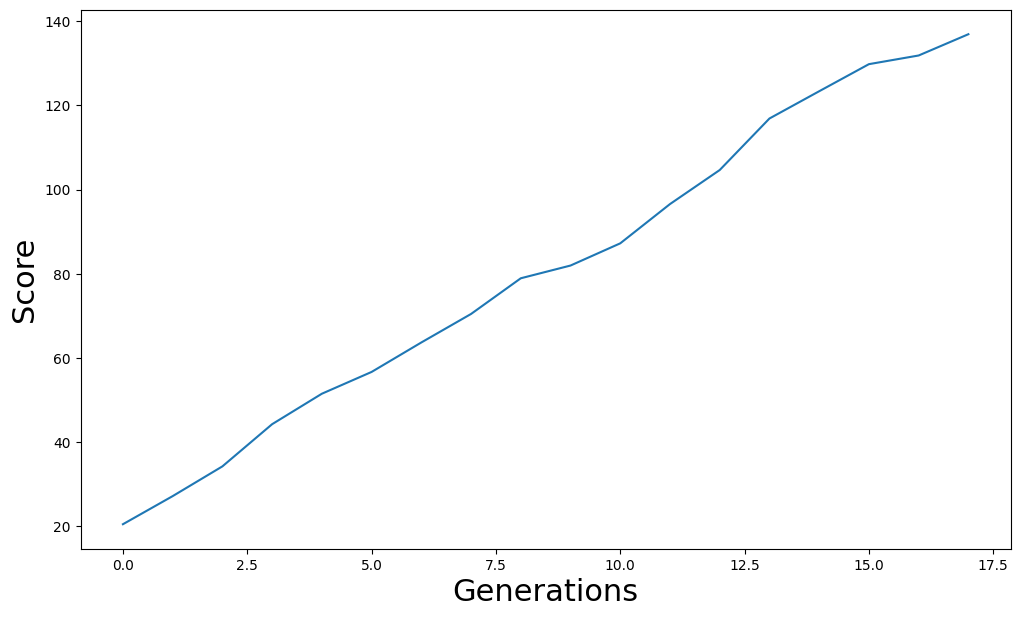

In [5]:
num_generations = 20
population_size = 500
mutation_rate = 0.01 # 0.1%
tournament_size = 0.2

layers = [(4, 25), (25, 10), (10, 2)]
pop = spawn_population(population_size, layers)
pop_fit = []

start = time.time()
for i in range(num_generations):
    print(f"Gen {i+1}")
    pop, avg_fit = evaluate_population(pop, layers) # 개체군 내 개체들에 적합도 점수를 부여하고, 개체들의 적합도 점수 평균을 반환한다
    pop_fit.append(avg_fit)
    pop = next_generation(pop, mutation_rate, tournament_size)
print(f"running time : {(time.time() - start) / 60:.4f} min")
print(f"max fitness of gene of final population : {max_gene(pop, layers)}")

''' 개체군 저장 '''
torch.save(pop, os.path.join(os.getcwd(), "parameters", "population3.pt"))

plt.figure(figsize=(12,7))
plt.xlabel("Generations", fontsize=22)
plt.ylabel("Score", fontsize=22)
plt.plot(running_mean(np.array(pop_fit), 3))

In [6]:
''' 최종 개체군 중 최고의 적합도를 가진 개체에 대한 카트폴 실험 '''

''' 프로세스 생성 및 실행 '''
p = mp.Process(target=worker, args=(pop, layers))
p.start()

''' 프로세스 종료 및 자원 회수 '''
p.join()
p.terminate()
p.close()

In [7]:
''' 최종 개체군 중 최고의 적합도를 가진 개체에 대한 카트폴 실험 '''

pop = torch.load(os.path.join(os.getcwd(), "parameters", "population3.pt"), weights_only=True)

''' 프로세스 생성 및 실행 '''
p = mp.Process(target=worker, args=(pop, [(4, 25), (25, 10), (10, 2)]))
p.start()

''' 프로세스 종료 및 자원 회수 '''
p.join()
p.terminate()
p.close()